#### Specify test options here

In [1]:
use_jpeg = True  # use JPEG or bitmap model input
exclude_preprocessing = True  # exclude preprocessing step from timing measurements
batch_size = None  # eager batch size to test; None to use default

COLAB = False

In [2]:
if COLAB:
    !pip show degirum-tools || pip install degirum-tools

Test parameters

In [3]:
iterationsL = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#iterationsL = [10, 20, 30]
model_suffixL = ['yolov5nu', 'yolov5su', 'yolov8n', 'yolov8s']

if COLAB:
    data_dir = '/content/drive/MyDrive/Colab Notebooks/data_dir/'
else:
    data_dir = '/home/gotom/data_dir/fps_value/'

#### Specify where do you want to run your inferences

In [4]:
import degirum as dg

if COLAB:
    import degirum_tools as dgtools
else:
    import dgtools   


Model ORCA1

In [5]:
model_orca1 = [
 'yolov5nu_relu6_car--640x640_quant_n2x_orca1_1',
 'yolov5su_relu6_car--640x640_quant_n2x_orca1_1',
 'yolov8n_relu6_car--640x640_quant_n2x_orca1_1',
 'yolov8s_relu6_car--640x640_quant_n2x_orca1_1',
 ]

In [6]:
# #For local orca1 model

# orca1_model_dir_name = '/home/gotom/model_zoo/orca1/' 
# yolov5nu_relu6_car_quant_dir = orca1_model_dir_name + 'yolov5nu_relu6_car--640x640_quant_n2x_orca1_1/yolov5nu_relu6_car--640x640_quant_n2x_orca1_1.json'
# yolov8n_relu6_car_quant_dir = orca1_model_dir_name + 'yolov8n_relu6_car--640x640_quant_n2x_orca1_1/yolov8n_relu6_car--640x640_quant_n2x_orca1_1.json'
# yolov5su_relu6_car_quant_dir = orca1_model_dir_name + 'yolov5su_relu6_car--640x640_quant_n2x_orca1_1/yolov5su_relu6_car--640x640_quant_n2x_orca1_1.json'
# yolov8s_relu6_car_quant_dir = orca1_model_dir_name + 'yolov8s_relu6_car--640x640_quant_n2x_orca1_1/yolov8s_relu6_car--640x640_quant_n2x_orca1_1.json'

# model_orca1_local = [yolov5nu_relu6_car_quant_dir, yolov8n_relu6_car_quant_dir, yolov5su_relu6_car_quant_dir, yolov8s_relu6_car_quant_dir,]

# model_orca1_zoo = [dg.connect(dg.LOCAL, model_orca1_local[i]) for i in range(len(model_orca1_local))]
# #model_orca1_zoo = [dg.connect(dg.LOCAL, dgtools.get_cloud_zoo_url(), dgtools.get_token()) for i in range(len(model_orca1))]


In [7]:
if COLAB:
    dgtools.configure_colab()

#### The rest of the cells below should run without any modifications

In [8]:
# define function to run a single model batch prediction
def do_test(target, model_name, iterations):
    
    if target == 'Local':
        zoo = dg.connect(dg.LOCAL, dgtools.get_cloud_zoo_url(), dgtools.get_token())
    elif target == 'Local_w_model':
        zoo = dg.connect(dg.LOCAL)
    else:
        if COLAB:
            dgtools.configure_colab()
        zoo = dg.connect(dg.CLOUD, dgtools.get_cloud_zoo_url(), dgtools.get_token())

    # load model
    with zoo.load_model(model_name) as model:

        # skip non-image type models
        if model.model_info.InputType[0] != "Image":
            return None

        # configure model
        model.input_image_format = "JPEG" if use_jpeg else "RAW"
        model.measure_time = True
        if batch_size is not None:
            model.eager_batch_size = batch_size
            model.frame_queue_depth = batch_size

        # prepare input frame
        frame = "../../images/Car.jpg"
        if exclude_preprocessing:
            frame = model._preprocessor.forward(frame)[0]

        # define source of frames
        def source():
            for fi in range(iterations):
                yield frame

        model(frame)  # run model once to warm up the system

        # run batch prediction
        t = dgtools.Timer()
        for res in model.predict_batch(source()):
            pass

        return {
            "postprocess_type": model.output_postprocess_type,
            "elapsed": t(),
            "time_stats": model.time_stats(),
        }


In [9]:
def get_observed_fps_value(model_name, res, iterations):
    
    frame_duration_ms = 1e3 * res["elapsed"] / iterations

    observed_fps = round((1e3/frame_duration_ms),1)
    
    return observed_fps

In [10]:
#*******************************************************************************************************
# draw_graph()
#*******************************************************************************************************

model_suffixL = ['yolov5nu', 'yolov5su', 'yolov8n', 'yolov8s']


def draw_graph(target, fpsL, fps_iteraqtions_100L, suffix): 
    import matplotlib.pyplot as plt

    #fpsL = [yolov5nu_fps, yolov5su_fps, yolov8n_fps, yolov8s_fps]
    #model_suffixL = ['yolov5nu', 'yolov5su', 'yolov8n', 'yolov8s']
   
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.rcParams["font.family"] = "Dejavu Serif"
    plt.rcParams["font.size"] = 8
    plt.rcParams["lines.linewidth"] = 1.5

    font = {'family' : 'Dejavu Serif', 'size' : 9, }
    
    #y_max = np.max(fpsL[0]) + 15
    y_max=110
    
    # for i in range(len(fpsL) - 1):
    #     if np.max(fpsL[i + 1]) > y_max:
    #         y_max = np.max(fpsL[i + i]) + 15
    
    ax1.set_ylim(0, y_max)
    
    colorL = ['green', 'blue', 'violet', 'cyan']
    markerfacecolorL = ['lightgreen', 'lightblue', 'plum', 'powderblue']

    x_interval = [val / 10 for val in iterationsL]
    plt.xticks(x_interval, iterationsL)

    for i in range(len(fpsL)):
        
        ax1.plot(x_interval, fpsL[i], color = colorL[i], label = model_suffixL[i] + '_' + str(round(fps_iteraqtions_100L[i],1)) + 'FPS@' + str(iterationsL[-1]) + 'iterations', marker = 'D', markersize = 5, 
                 markeredgewidth = 1, markeredgecolor = colorL[i], markerfacecolor = markerfacecolorL[i])
    
    ax1.set_xlabel('Iterations', fontdict=font)
    ax1.set_ylabel('FPS', fontdict=font)

    ax1.legend(loc = 'upper center')

    if COLAB:
        plt.title('Image Input FPS(Colab)')
    else:
        plt.title('Image Input FPS('+ target +')')
        
    plt.show()
    #suffix = '11'

    if COLAB:    
        fig.savefig(data_dir + 'fps_comp(Colab)' + suffix + '.jpg')
    else:
        fig.savefig(data_dir + 'fps_comp(' + target +')' + suffix + '.jpg')

In [11]:
def single_test(target):

    yolov5nu_fps = []
    yolov5su_fps = []
    yolov8n_fps = []
    yolov8s_fps = []

    for i in range(len(iterationsL)):  
                
        results = {}   
    
        for model_name in model_orca1:
            if target == 'Local':
                results[model_name] = do_test('Local', model_name, iterationsL[i])
            elif target == 'Local_w_model':
                results[model_name] = do_test('Local_model', model_name, iterationsL[i])
            else:
                results[model_name] = do_test('Cloud', model_name, iterationsL[i])
                
        for model_name, res in results.items():
            if res is not None:
                fps_value = get_observed_fps_value(model_name, res, iterationsL[i]) 
        
            if  not model_name.find('5nu') == -1:
                yolov5nu_fps.append(fps_value)
            elif not model_name.find('5su') == -1:
                yolov5su_fps.append(fps_value)
            elif not model_name.find('8n') == -1:
                yolov8n_fps.append(fps_value)
            elif not model_name.find('8s') == -1:
                yolov8s_fps.append(fps_value)
    
    fpsL = [yolov5nu_fps, yolov5su_fps, yolov8n_fps, yolov8s_fps]
    
    return fpsL

In [12]:
test_count = 3
#target = 'Cloud'
target = 'Local'
fpsD = {}

for i in range(test_count):
    fpsD[i] = single_test(target)
    print(fpsD)

#print(fpsD)

{0: [[52.1, 83.9, 88.4, 90.4, 92.3, 91.6, 92.3, 93.8, 95.0, 94.1], [38.8, 40.1, 41.1, 40.3, 41.8, 42.0, 42.1, 42.1, 42.4, 42.4], [47.2, 82.1, 82.0, 77.8, 80.8, 86.5, 86.9, 87.0, 87.6, 87.8], [33.3, 34.2, 35.3, 36.5, 36.4, 36.2, 36.3, 36.4, 36.2, 36.5]]}
{0: [[52.1, 83.9, 88.4, 90.4, 92.3, 91.6, 92.3, 93.8, 95.0, 94.1], [38.8, 40.1, 41.1, 40.3, 41.8, 42.0, 42.1, 42.1, 42.4, 42.4], [47.2, 82.1, 82.0, 77.8, 80.8, 86.5, 86.9, 87.0, 87.6, 87.8], [33.3, 34.2, 35.3, 36.5, 36.4, 36.2, 36.3, 36.4, 36.2, 36.5]], 1: [[73.6, 86.6, 86.7, 91.6, 91.4, 91.7, 93.5, 93.9, 94.2, 94.3], [37.4, 40.2, 41.3, 41.6, 41.8, 42.0, 42.2, 42.2, 42.3, 42.4], [71.7, 79.6, 83.6, 84.6, 85.7, 86.3, 86.8, 88.8, 87.6, 87.7], [33.0, 34.9, 35.5, 35.9, 36.0, 36.1, 36.3, 36.4, 36.4, 36.4]]}
{0: [[52.1, 83.9, 88.4, 90.4, 92.3, 91.6, 92.3, 93.8, 95.0, 94.1], [38.8, 40.1, 41.1, 40.3, 41.8, 42.0, 42.1, 42.1, 42.4, 42.4], [47.2, 82.1, 82.0, 77.8, 80.8, 86.5, 86.9, 87.0, 87.6, 87.8], [33.3, 34.2, 35.3, 36.5, 36.4, 36.2, 36.3, 36.4,

[67.03333333 85.73333333 87.96666667 90.16666667 91.33333333 92.2
 93.16666667 93.86666667 93.93333333 95.66666667]
[38.2        40.26666667 41.26666667 41.16666667 41.7        42.1
 42.2        42.26666667 42.56666667 42.63333333]
[63.46666667 80.46666667 82.9        82.2        83.2        86.5
 85.76666667 87.8        88.13333333 88.23333333]
[33.36666667 34.66666667 35.36666667 36.1        36.13333333 36.2
 36.26666667 36.33333333 36.5        36.56666667]
[[67.03333333333333, 85.73333333333333, 87.96666666666668, 90.16666666666667, 91.33333333333333, 92.2, 93.16666666666667, 93.86666666666667, 93.93333333333332, 95.66666666666667], [38.199999999999996, 40.26666666666667, 41.26666666666667, 41.166666666666664, 41.699999999999996, 42.1, 42.2, 42.26666666666667, 42.56666666666666, 42.63333333333333], [63.46666666666667, 80.46666666666665, 82.89999999999999, 82.19999999999999, 83.2, 86.5, 85.76666666666665, 87.8, 88.13333333333333, 88.23333333333333], [33.36666666666667, 34.66666666666

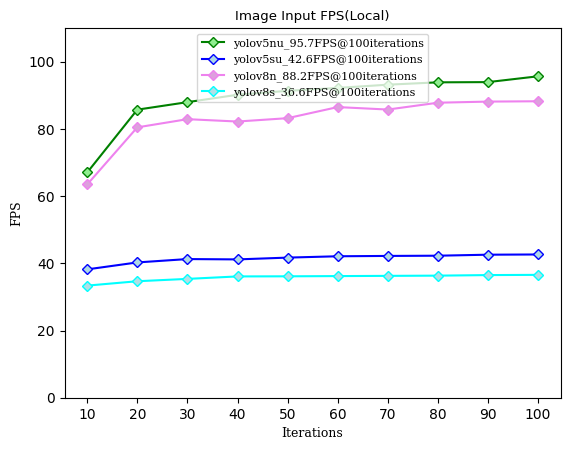

In [13]:
import numpy as np
yolov5nu_ave_arr = np.array(fpsD[0][0])
yolov5su_ave_arr = np.array(fpsD[0][1])
yolov8n_ave_arr = np.array(fpsD[0][2])
yolov8s_ave_arr = np.array(fpsD[0][3])

#yolov5nu_fps
for i in range(1, len(fpsD)):
    yolov5nu_ave_arr += np.array(fpsD[i][0]) 

yolov5nu_ave_arr = yolov5nu_ave_arr / test_count
print(yolov5nu_ave_arr)

#yolov5su_fps
for i in range(1, len(fpsD)):
    yolov5su_ave_arr += np.array(fpsD[i][1]) 

yolov5su_ave_arr = yolov5su_ave_arr / test_count
print(yolov5su_ave_arr)

#yolov8n_fps
for i in range(1, len(fpsD)):
    yolov8n_ave_arr += np.array(fpsD[i][2]) 

yolov8n_ave_arr = yolov8n_ave_arr / test_count
print(yolov8n_ave_arr)

#yolov8s_fps
for i in range(1, len(fpsD)):
    yolov8s_ave_arr += np.array(fpsD[i][3]) 

yolov8s_ave_arr = yolov8s_ave_arr / test_count
print(yolov8s_ave_arr)

fpsL = [yolov5nu_ave_arr.tolist(), yolov5su_ave_arr.tolist(), yolov8n_ave_arr.tolist(), yolov8s_ave_arr.tolist()]

fps_iterations_100L = []

for i in range(len(fpsL)):
    fps_iterations_100L.append(fpsL[i][-1])

print(fpsL)
print(fps_iterations_100L)

suffix = '_13'
draw_graph(target, fpsL, fps_iterations_100L, suffix)

In [14]:
""" # run batch predict for each model and record time measurements
#model_names = [model_orca1, model_edgetpu]

import numpy as np
import my_utils as mutil

#iterationsL = [100, 200, 300, 400, 500, 600, 700, 800, 1000]
#iterationsL = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#observed_fps = {}

# yolov5nu_fps = []
# yolov5su_fps = []
# yolov8n_fps = []
# yolov8s_fps = []


for i in range(len(iterationsL)):
        
    results = {}   
    
    for model_name in model_orca1:
        results[model_name] = do_test('Local', model_name, iterationsL[i])
    
    for model_name, res in results.items():
        if res is not None:
            fps_value = get_observed_fps_value(model_name, res, iterationsL[i]) 
        
        if  not model_name.find('5nu') == -1:
            yolov5nu_fps.append(fps_value)
        elif not model_name.find('5su') == -1:
            yolov5su_fps.append(fps_value)
        elif not model_name.find('8n') == -1:
            yolov8n_fps.append(fps_value)
        elif not model_name.find('8s') == -1:
            yolov8s_fps.append(fps_value)

print(f'yolov5nu_fps_local = {yolov5nu_fps}')
print(f'yolov5su_fps_local = {yolov5su_fps}')
print(f'yolov8n_fps_local = {yolov8n_fps}')
print(f'yolov8s_fps_local = {yolov8s_fps}')
            
    # yolov5nu_fps_arr = mutil.save_fps_array(data_dir, device, yolov5nu_fps, False, 'debug')
    # yolov5su_fps_arr = mutil.save_fps_array(data_dir, device, yolov5su_fps, False, 'debug')
    # yolov8n_fps_arr = mutil.save_fps_array(data_dir, device, yolov8n_fps, False, 'debug')
    # yolov8s_fps_arr = mutil.save_fps_array(data_dir, device, yolov8s_fps, False, 'debug')

    #fpsL = [yolov5nu_fps, yolov5su_fps, yolov8n_fps, yolov8s_fps]
    #model_suffixL = ['yolov5nu', 'yolov5su', 'yolov8n', 'yolov8s']

fpsL = [yolov5nu_fps, yolov5su_fps, yolov8n_fps, yolov8s_fps]
draw_graph(target, fpsL) """

" # run batch predict for each model and record time measurements\n#model_names = [model_orca1, model_edgetpu]\n\nimport numpy as np\nimport my_utils as mutil\n\n#iterationsL = [100, 200, 300, 400, 500, 600, 700, 800, 1000]\n#iterationsL = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]\n#observed_fps = {}\n\n# yolov5nu_fps = []\n# yolov5su_fps = []\n# yolov8n_fps = []\n# yolov8s_fps = []\n\n\nfor i in range(len(iterationsL)):\n        \n    results = {}   \n    \n    for model_name in model_orca1:\n        results[model_name] = do_test('Local', model_name, iterationsL[i])\n    \n    for model_name, res in results.items():\n        if res is not None:\n            fps_value = get_observed_fps_value(model_name, res, iterationsL[i]) \n        \n        if  not model_name.find('5nu') == -1:\n            yolov5nu_fps.append(fps_value)\n        elif not model_name.find('5su') == -1:\n            yolov5su_fps.append(fps_value)\n        elif not model_name.find('8n') == -1:\n            yolov8n_fps

In [15]:
""" #*******************************************************************************************************
# draw_graph()
#*******************************************************************************************************
    
import matplotlib.pyplot as plt

fpsL = [yolov5nu_fps, yolov5su_fps, yolov8n_fps, yolov8s_fps]
model_suffixL = ['yolov5nu', 'yolov5su', 'yolov8n', 'yolov8s']

#fpsL = [yolov5nu_fps]
#model_suffixL = ['yolov5nu']
    
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.rcParams["font.family"] = "Dejavu Serif"
plt.rcParams["font.size"] = 8
plt.rcParams["lines.linewidth"] = 1.5

font = {'family' : 'Dejavu Serif',
            'size' : 9,
}
    
#y_max = np.max(fpsL[0]) + 15
y_max=110
    
for i in range(len(fpsL) - 1):
    if np.max(fpsL[i + 1]) > y_max:
            y_max = np.max(fpsL[i + i]) + 15
    
ax1.set_ylim(0, y_max)
    
colorL = ['green', 'blue', 'violet', 'cyan']
markerfacecolorL = ['lightgreen', 'lightblue', 'plum', 'powderblue']

x_interval = [val / 10 for val in iterationsL]
plt.xticks(x_interval, iterationsL)

for i in range(len(fpsL)):
        
    ax1.plot(x_interval, fpsL[i], color = colorL[i], label = model_suffixL[i], marker = 'D', markersize = 5, 
             markeredgewidth = 1, markeredgecolor = colorL[i], markerfacecolor = markerfacecolorL[i])
    
ax1.set_xlabel('Iterations', fontdict=font)
ax1.set_ylabel('FPS', fontdict=font)

ax1.legend(loc = 'upper center')

plt.title('Image Input FPS('+ target +')')
    
plt.show()
suffix = 'debug'
fig.savefig(data_dir + 'fps_comp(' + target +').jpg')
 """

' #*******************************************************************************************************\n# draw_graph()\n#*******************************************************************************************************\n    \nimport matplotlib.pyplot as plt\n\nfpsL = [yolov5nu_fps, yolov5su_fps, yolov8n_fps, yolov8s_fps]\nmodel_suffixL = [\'yolov5nu\', \'yolov5su\', \'yolov8n\', \'yolov8s\']\n\n#fpsL = [yolov5nu_fps]\n#model_suffixL = [\'yolov5nu\']\n    \nfig = plt.figure()\nax1 = fig.add_subplot(111)\n\nplt.rcParams["font.family"] = "Dejavu Serif"\nplt.rcParams["font.size"] = 8\nplt.rcParams["lines.linewidth"] = 1.5\n\nfont = {\'family\' : \'Dejavu Serif\',\n            \'size\' : 9,\n}\n    \n#y_max = np.max(fpsL[0]) + 15\ny_max=110\n    \nfor i in range(len(fpsL) - 1):\n    if np.max(fpsL[i + 1]) > y_max:\n            y_max = np.max(fpsL[i + i]) + 15\n    \nax1.set_ylim(0, y_max)\n    \ncolorL = [\'green\', \'blue\', \'violet\', \'cyan\']\nmarkerfacecolorL = [\'lightgreen